In [1]:
# list all files in a directory

import os

pos = []
for file in os.listdir('./aclImdb/train/pos'):
  fd = open(f'./aclImdb/train/pos/{file}')
  x = fd.read()
  pos.append(x)

neg = []
for file in os.listdir('./aclImdb/train/neg'):
  fd = open(f'./aclImdb/train/neg/{file}')
  x = fd.read()
  neg.append(x)

unsup = []
for file in os.listdir('./aclImdb/train/unsup'):
  fd = open(f'./aclImdb/train/unsup/{file}')
  x = fd.read()
  unsup.append(x)

print(len(pos), len(neg), len(unsup))


12500 12500 50000


In [2]:
import pandas as pd

df_pos = pd.DataFrame(pos, columns=['text'])
df_neg = pd.DataFrame(neg, columns=['text'])
df_unsup = pd.DataFrame(unsup, columns=['text'])

df_pos['label'] = 0
df_neg['label'] = 1
df_unsup['label'] = 2

df_pos['set'] = 'train'
df_neg['set'] = 'train'
df_unsup['set'] = 'train'

df = pd.concat([df_pos[0:200], df_neg[0:200], df_unsup[0:200]])
df.head()

,text,label,set
0,For a movie that gets no respect there sure ar...,0,train
1,Bizarre horror movie filled with famous faces ...,0,train
2,"A solid, if unremarkable film. Matthau, as Ein...",0,train
3,It's a strange feeling to sit alone in a theat...,0,train
4,"You probably all already know this by now, but...",0,train


In [3]:
df.iloc(0)

In [4]:
import os
import openai
from dotenv import load_dotenv
load_dotenv()

openai.organization = "org-ITye4e6Cusa0BUGY6ucHrfq3"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.Model.list()

<OpenAIObject list at 0x7fbe3c615400> JSON: {
  "data": [
    {
      "created": 1649358449,
      "id": "babbage",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          "allow_sampling": true,
          "allow_search_indices": false,
          "allow_view": true,
          "created": 1669085501,
          "group": null,
          "id": "modelperm-49FUp5v084tBB49tC4z8LPH5",
          "is_blocking": false,
          "object": "model_permission",
          "organization": "*"
        }
      ],
      "root": "babbage"
    },
    {
      "created": 1649359874,
      "id": "davinci",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          "allow_sa

In [5]:
print(len(df))

600


In [11]:
# https://github.com/openai/openai-cookbook/blob/main/examples/Embedding_long_inputs.ipynb

from tenacity import retry, wait_random_exponential, stop_after_attempt, retry_if_not_exception_type
import time
import numpy as np

EMBEDDING_MODEL = 'text-embedding-ada-002'

@retry(
  wait=wait_random_exponential(min=2, max=10), 
  stop=stop_after_attempt(6), 
  retry=retry_if_not_exception_type(openai.InvalidRequestError))
def get_embedding(text_or_tokens, model=EMBEDDING_MODEL):
  print('calling open ai', time.time())
  res = openai.Embedding.create(input=text_or_tokens, model=model)
  time.sleep(1)
  embedding = res['data'][0]['embedding']
  return np.array(embedding, dtype=np.float32)


df['embedding'] = df['text'].apply(get_embedding)

calling open ai 1676610099.995928
calling open ai 1676610101.433654
calling open ai 1676610102.5453298


In [10]:
df['embedding']

KeyError: 'embedding'

In [63]:
df['embedding'].describe()

KeyError: 'embedding'

<Axes: ylabel='label'>

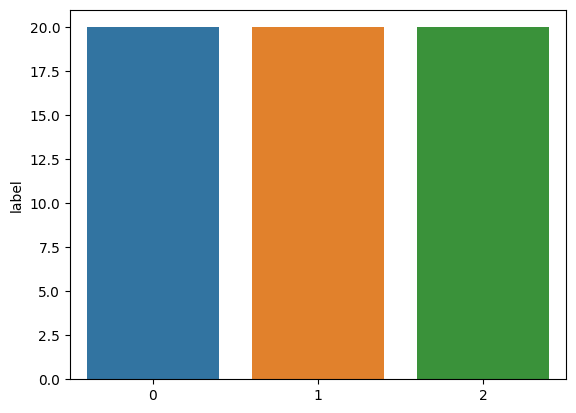

In [51]:
# seaborn bar chart of labels 
import seaborn as sns

sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts())

In [52]:
df.head()

,text,label,set,embedding
0,For a movie that gets no respect there sure ar...,0,train,"[-0.009237849, -0.019371409, 0.0018398828, -0...."
1,Bizarre horror movie filled with famous faces ...,0,train,"[0.00057595933, -0.025075123, 0.0180585, -0.00..."
2,"A solid, if unremarkable film. Matthau, as Ein...",0,train,"[-0.011860691, -0.01004855, 0.0037747482, -0.0..."
3,It's a strange feeling to sit alone in a theat...,0,train,"[0.020455169, -0.025746237, -0.012661749, -0.0..."
4,"You probably all already know this by now, but...",0,train,"[0.00013183967, -0.03380402, -0.0061724177, -0..."


(60, 1536)
[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.210659
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.793213
[t-SNE] KL divergence after 300 iterations: 0.184030


<Axes: xlabel='x', ylabel='y'>

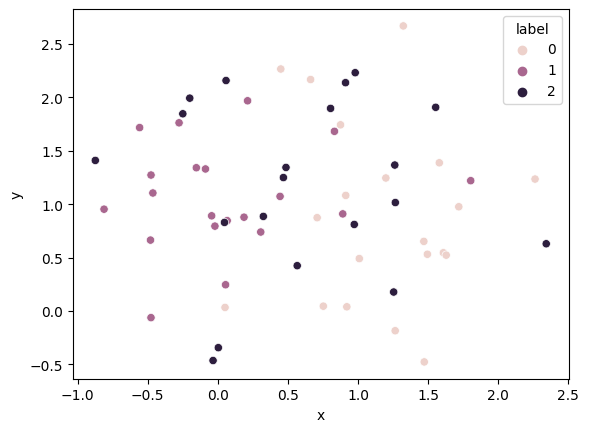

In [55]:
# tsne plot of embeddings for each label
from sklearn.manifold import TSNE

samples = df['embedding'].to_list()
X = np.array(samples)

print(X.shape)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['label'] = np.array(df['label'].to_list())

sns.scatterplot(x='x', y='y', hue='label', data=df_tsne)